In [11]:
# 05. Detecting and filtering outliers

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [13]:
# Create a random seed to make result reproducible
np.random.seed(0)


In [14]:
# Create 5 features with 100000 samples from Gaussian distribution each
df = pd.DataFrame(np.random.randn(100000, 5))



In [15]:
# Add 1000 to the last 100 values of feature 4
df.iloc[-100:, 4] = df.iloc[-100:, 4] + 1000



In [16]:
# Create 6th feature with 100000 samples from exponential distribution
df[5] = np.random.exponential(1, 100000)



In [17]:
# Change feature names
df = df.add_prefix("X")
df.head()

,X0,X1,X2,X3,X4,X5
0,1.764052,0.400157,0.978738,2.240893,1.867558,0.540426
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,1.424513
2,0.144044,1.454274,0.761038,0.121675,0.443863,0.282623
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,0.038750
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0.999036


In [18]:
# check some common statistics.
df.describe().round(5)


,X0,X1,X2,X3,X4,X5
count,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000
mean,-0.00020,0.00235,0.00161,0.00196,1.00745,1.00622
std,0.99711,0.99915,1.00225,1.00057,31.61742,1.00696
min,-4.69459,-4.85212,-4.24712,-4.44663,-5.00230,0.00000
25%,-0.67891,-0.66917,-0.67574,-0.67561,-0.66450,0.29055
50%,0.00263,0.00315,0.00039,0.00118,0.00851,0.69563
75%,0.67424,0.67192,0.67740,0.67603,0.68245,1.39619
max,4.46661,4.22408,4.28586,4.24177,1002.53804,11.80068


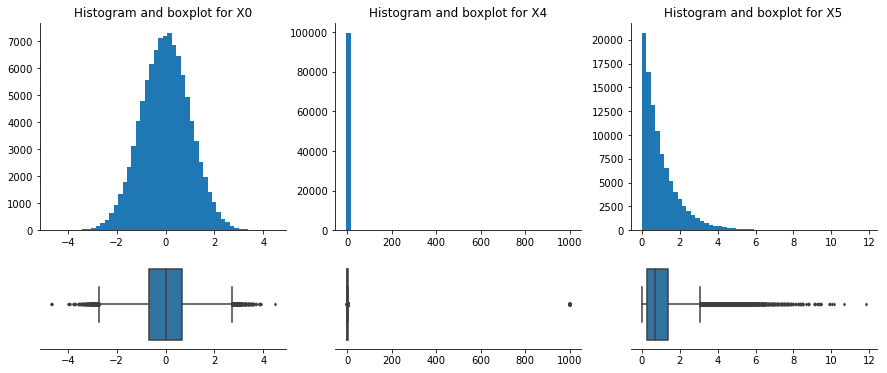

In [25]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(df[feat], ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

## manual outlier removal 

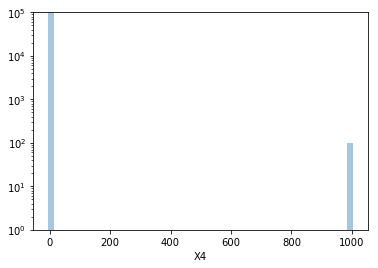

In [28]:
#visula inspection
sns.distplot(df["X4"], kde=False)
plt.yscale("log")
plt.ylim(1, 100000)
plt.show()

In [29]:
filter_200 = df["X4"] > 200
outliers_manual = df.loc[filter_200, "X4"]
outliers_manual.head()


99900     999.019554
99901    1000.315769
99902    1000.443100
99903    1001.435870
99904    1000.534458
Name: X4, dtype: float64

In [30]:
df_keep = df.loc[~filter_200, "X4"]
df_keep.shape

(99900,)

## Using Z-scores to identify outlier candidates


In [32]:
zfilterX0 = np.abs(df["X0"] - df["X0"].mean()) > (3 * df["X0"].std())
zfilterX0.head()

0    False
1    False
2    False
3    False
4    False
Name: X0, dtype: bool

In [33]:
df.loc[zfilterX0, "X0"].head()

1470    3.211847
2763   -3.694285
3178   -3.007413
3809    3.301367
3833   -3.432215
Name: X0, dtype: float64

In [34]:
zfilter_df = np.abs(df - df.mean()) > (3 * df.std())

In [36]:
zscores_df = (df - df.mean()) / (df.std())
zfilter_df2 = np.abs(zscores_df) > 3
# Check the two zfilters are identical
print("Both approaches are equivalent:", zfilter_df.equals(zfilter_df2))

Both approaches are equivalent: True


In [37]:
print("Number of outliers detected per feature using z-scores:")
print(zfilter_df.sum(axis=0))
print("Total number of outliers detected:", zfilter_df.sum(axis=0).sum())


Number of outliers detected per feature using z-scores:
X0     255
X1     290
X2     272
X3     271
X4     100
X5    1858
dtype: int64
Total number of outliers detected: 3046


## Filtering outliers using all features
* axis=0 gives a value to each column: True if there was a True entry anywhere in the column, and False otherwise
* axis=1 gives a value to each row: True if there was a True entry anywhere in the row, and False otherwise.

In [39]:
zfilter_any  = zfilter_df.any(axis=1)
zfilter_any.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [40]:
outliers = df.loc[zfilter_any, :]
outliers.shape

(3018, 6)

In [44]:
df_wo = df.drop(outliers.index, axis=0)

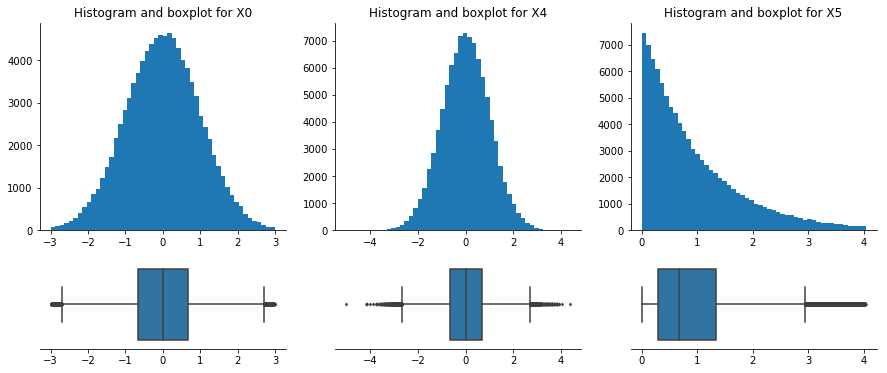

In [45]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df_wo[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(df_wo[feat], ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

## Using the interquartile range to identify outlier candidates

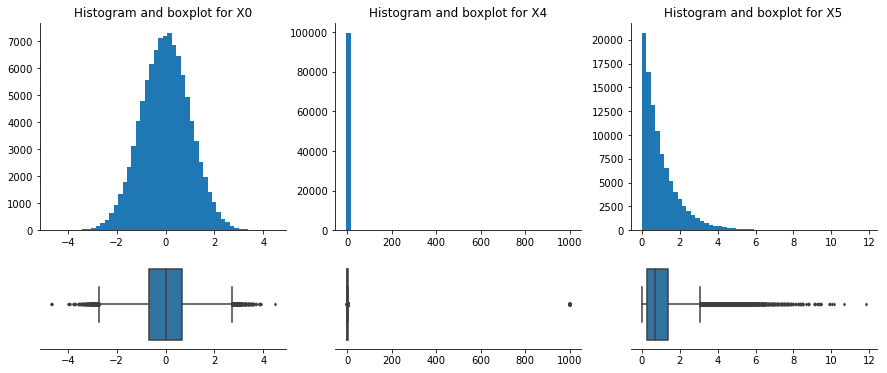

In [46]:
fig, axes = plt.subplots(
    2, 3, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(15, 6)
)

for (feat, plot_col) in zip(
    ["X0", "X4", "X5"], [0, 1, 2]  # pairing feature with column in plot
):  
    axes[0, plot_col].hist(df[feat], bins=50)
    axes[0, plot_col].set_title("Histogram and boxplot for {}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(df[feat], ax=axes[1, plot_col], fliersize=2)
    axes[1, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

In [47]:
#calculating the upper and lower bounds directly from the IQR of each feature.
Q1 = np.percentile(df, 25, axis=0)
Q3 = np.percentile(df, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Print lower and upper bound for X0
print("Lower bound: {:.4f}, upper bound: {:.4f}".format(lower_bound[0], upper_bound[0]))


Lower bound: -2.7087, upper bound: 2.7040


In [48]:
#  We now use boolean indexing to select the entries which lie outside our bounds. Let's check how many outliers are identified by the boxplot in each feature.
boxplot_filter = (df < lower_bound) | (df > upper_bound)
print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())


Number of outliers detected per feature using a boxplot:
X0     648
X1     757
X2     679
X3     687
X4     818
X5    4742
dtype: int64
Total number of outliers detected: 8331


## Problems with outlier detection methods
The data contains multiple sub-populations